In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import comet_ml
from comet_ml import Experiment

In [3]:
import os,sys
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CometLogger

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})

In [5]:
sys.path.append('../training')
from manifoldembedder import *
from anomalymodels import *

In [11]:
aemodel = AutoEncoder.load_from_checkpoint("./autoencoder_checkpoints/autoencoder-paper1-checkpoint-epoch=09-val_loss=0.014.ckpt")
mlp = MLP.load_from_checkpoint("./mlp_checkpoints/mlp-paper1-checkpoint-epoch=17-val_loss=0.23.ckpt")

In [7]:
basedir = '/nobackup/users/sangeon/datasets/jetGridpack/jetanomaly'

qcd_dict = {'train':os.path.join(basedir, 'autoencoder_train.pt'),
             'val':os.path.join(basedir, 'autoencoder_val.pt'),
             'test':os.path.join(basedir, 'autoencoder_predict.pt'),
             'predict':os.path.join(basedir, 'autoencoder_predict.pt')}

qcd_original_set = torch.load(os.path.join(basedir, 'autoencoder_predict.pt'))


basedir = '/nobackup/users/sangeon/datasets/jetGridpack/jetpairs'
mixture_dict = {'train':os.path.join(basedir, 'Gridpack_jettrain_16part_merged.pt'),
             'val':os.path.join(basedir, 'Gridpack_jetval_16part_merged.pt'),
             'test':os.path.join(basedir, 'Gridpack_jetpredict_16part_merged.pt'),
             'predict':os.path.join(basedir, 'Gridpack_jetpredict_16part_merged.pt')}


mixture_original_set = torch.load(os.path.join(basedir, 'Gridpack_jetpredict_16part_merged.pt'))
mixture_secondensemble_set = torch.load(os.path.join(basedir, 'Gridpack_jetpair_secondensemble_predict.pt'))

In [8]:
mixture_dict2 = {'train':os.path.join(basedir, 'Gridpack_jettrain_16part_merged.pt'),
             'val':os.path.join(basedir, 'Gridpack_jetval_16part_merged.pt'),
             'test':os.path.join(basedir, 'Gridpack_jetpredict_16part_merged.pt'),
             'predict':os.path.join(basedir, 'Gridpack_jetpair_secondensemble_predict.pt')}
mixture_original_set2 = torch.load(os.path.join(basedir, 'Gridpack_jetpair_secondensemble_predict.pt'))

In [8]:
qcd_dm = AnomalyDataModule(qcd_dict,2500)
mixture_dm = JetDataModule(mixture_dict,2500)



In [9]:
mixture_dm2 = JetDataModule(mixture_dict2,2500)


In [10]:
trainer = Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [19]:
#mlp_qcd     = trainer.predict(mlp, qcd_dm)
mlp_mixture2 = trainer.predict(mlp, mixture_dm2)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [24]:
mlp_mixtureloss2 = np.array([])

for batch in mlp_mixture2:

    mlp_mixtureloss2 = np.concatenate([mlp_mixtureloss2, torch.squeeze(batch).cpu().numpy()])


In [25]:
mlp_mixtureloss2.shape

(700000,)

In [26]:
mlp_mixtureloss2 = mlp_mixtureloss2[100000:]

with open('mlp_sigloss2.pickle', 'wb') as handle:
    pickle.dump(mlp_mixtureloss2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def get_loss(model, dm, originalset):
    predicted_set = trainer.predict(model, dm)
    prediction = np.empty((0,48))
    for batch in predicted_set:
        prediction = np.vstack((prediction, batch.cpu().numpy()))
    

    original = np.empty((0,48))
    originalloader = DataLoader(originalset, batch_size=1000)
    for batch, _ in originalloader:

        original = np.vstack((original, batch.cpu().numpy().reshape(-1,48)))
    
    loss = nn.MSELoss(reduction='none')
    loss_result = torch.sum(loss(torch.FloatTensor(prediction),torch.FloatTensor(original)),dim=1)
    return loss_result.cpu().numpy()

In [16]:
def get_predictx(originalset):
    original = np.empty((0,48))
    originalloader = DataLoader(originalset, batch_size=1000)
    for batch, _ in originalloader:
        #print(batch.size())
        original = np.vstack((original, batch.cpu().numpy().reshape(-1,48)))
    return original

In [18]:
mixtureloss2 = get_loss(aemodel, mixture_dm2, mixture_original_set2)


/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/nobackup/users/sangeon/condas/anaconda3/envs/studies/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


In [20]:
mixtureloss2.shape

(700000,)

In [21]:
mixtureloss2 = mixtureloss2[100000:]


In [22]:
mixtureloss2.shape

(600000,)

In [23]:
with open('AE_sigloss2.pickle', 'wb') as handle:
    pickle.dump(mixtureloss2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
original2 = get_predictx(mixture_original_set2)


In [29]:
original2.shape

(700000, 48)

In [30]:
original2 = original2[100000:]


In [ ]:
#qcdoriginal = get_predictx(qcd_original_set)

original = get_predictx(mixture_original_set)

original = original[100000:]

#qcdloss = get_loss(model, qcd_dm, qcd_original_set)

mixtureloss = get_loss(model, mixture_dm, mixture_original_set)

qcdloss.shape

mixtureloss.shape

mixtureloss = mixtureloss[100000:]

mixtureloss.shape

with open('AE_qcdloss.pickle', 'wb') as handle:
    pickle.dump(qcdloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('AE_sigloss.pickle', 'wb') as handle:
    pickle.dump(mixtureloss, handle, protocol=pickle.HIGHEST_PROTOCOL)







mixtureloss = mixtureloss[100000:]

with open('mlp_qcdloss.pickle', 'wb') as handle:
    pickle.dump(mlp_qcdloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('mlp_sigloss.pickle', 'wb') as handle:
    pickle.dump(mlp_mixtureloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-finaltuning-try14-epoch=00-val_loss=0.27.ckpt")

embedder.eval()

ManifoldEmbedder(
  (encoder): particleTransformer(
    (embed_src): Linear(in_features=3, out_features=32, bias=True)
    (embed_tgt): Linear(in_features=3, out_features=32, bias=True)
    (pos_enc): PositionalEncoding(
      (dropout): Dropout(p=0.25, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): Tra

In [31]:
inference_loader2 = DataLoader(torch.FloatTensor(original2),batch_size=5000)

from tqdm import tqdm

embedded2 = np.empty((0,2))
for batch in tqdm(inference_loader2):
    print(batch.size(0))
    embedded2 = np.vstack([embedded2, embedder(batch.view(batch.size(0), 16, 3)).detach().numpy()])



  0%|          | 0/120 [00:00<?, ?it/s]

5000


  1%|          | 1/120 [00:08<16:51,  8.50s/it]

5000


  2%|▏         | 2/120 [00:17<16:46,  8.53s/it]

5000


  2%|▎         | 3/120 [00:25<16:37,  8.52s/it]

5000


  3%|▎         | 4/120 [00:34<16:28,  8.52s/it]

5000


  4%|▍         | 5/120 [00:42<16:20,  8.53s/it]

5000


  5%|▌         | 6/120 [00:51<16:11,  8.52s/it]

5000


  6%|▌         | 7/120 [00:59<16:02,  8.52s/it]

5000


  7%|▋         | 8/120 [01:08<15:54,  8.52s/it]

5000


  8%|▊         | 9/120 [01:16<15:48,  8.54s/it]

5000


  8%|▊         | 10/120 [01:25<15:39,  8.54s/it]

5000


  9%|▉         | 11/120 [01:33<15:33,  8.56s/it]

5000


 10%|█         | 12/120 [01:42<15:23,  8.55s/it]

5000


 11%|█         | 13/120 [01:50<15:14,  8.55s/it]

5000


 12%|█▏        | 14/120 [01:59<15:05,  8.54s/it]

5000


 12%|█▎        | 15/120 [02:08<14:56,  8.54s/it]

5000


 13%|█▎        | 16/120 [02:16<14:49,  8.55s/it]

5000


 14%|█▍        | 17/120 [02:25<14:38,  8.53s/it]

5000


 15%|█▌        | 18/120 [02:33<14:29,  8.53s/it]

5000


 16%|█▌        | 19/120 [02:42<14:20,  8.52s/it]

5000


 17%|█▋        | 20/120 [02:50<14:11,  8.52s/it]

5000


 18%|█▊        | 21/120 [02:59<14:04,  8.53s/it]

5000


 18%|█▊        | 22/120 [03:07<13:58,  8.55s/it]

5000


 19%|█▉        | 23/120 [03:16<13:50,  8.56s/it]

5000


 20%|██        | 24/120 [03:24<13:41,  8.56s/it]

5000


 21%|██        | 25/120 [03:33<13:36,  8.59s/it]

5000


 22%|██▏       | 26/120 [03:42<13:28,  8.60s/it]

5000


 22%|██▎       | 27/120 [03:50<13:19,  8.60s/it]

5000


 23%|██▎       | 28/120 [03:59<13:11,  8.60s/it]

5000


 24%|██▍       | 29/120 [04:07<13:01,  8.59s/it]

5000


 25%|██▌       | 30/120 [04:16<12:52,  8.59s/it]

5000


 26%|██▌       | 31/120 [04:25<12:43,  8.58s/it]

5000


 27%|██▋       | 32/120 [04:33<12:36,  8.59s/it]

5000


 28%|██▊       | 33/120 [04:42<12:27,  8.59s/it]

5000


 28%|██▊       | 34/120 [04:50<12:18,  8.59s/it]

5000


 29%|██▉       | 35/120 [04:59<12:10,  8.59s/it]

5000


 30%|███       | 36/120 [05:08<12:00,  8.58s/it]

5000


 31%|███       | 37/120 [05:16<11:51,  8.57s/it]

5000


 32%|███▏      | 38/120 [05:25<11:43,  8.58s/it]

5000


 32%|███▎      | 39/120 [05:33<11:36,  8.60s/it]

5000


 33%|███▎      | 40/120 [05:42<11:26,  8.58s/it]

5000


 34%|███▍      | 41/120 [05:50<11:16,  8.57s/it]

5000


 35%|███▌      | 42/120 [05:59<11:06,  8.55s/it]

5000


 36%|███▌      | 43/120 [06:08<11:00,  8.58s/it]

5000


 37%|███▋      | 44/120 [06:16<10:50,  8.56s/it]

5000


 38%|███▊      | 45/120 [06:25<10:41,  8.55s/it]

5000


 38%|███▊      | 46/120 [06:33<10:32,  8.55s/it]

5000


 39%|███▉      | 47/120 [06:42<10:22,  8.53s/it]

5000


 40%|████      | 48/120 [06:50<10:13,  8.52s/it]

5000


 41%|████      | 49/120 [06:59<10:04,  8.51s/it]

5000


 42%|████▏     | 50/120 [07:07<09:55,  8.51s/it]

5000


 42%|████▎     | 51/120 [07:16<09:47,  8.52s/it]

5000


 43%|████▎     | 52/120 [07:24<09:39,  8.52s/it]

5000


 44%|████▍     | 53/120 [07:33<09:33,  8.56s/it]

5000


 45%|████▌     | 54/120 [07:41<09:24,  8.55s/it]

5000


 46%|████▌     | 55/120 [07:50<09:14,  8.54s/it]

5000


 47%|████▋     | 56/120 [07:58<09:04,  8.51s/it]

5000


 48%|████▊     | 57/120 [08:07<08:56,  8.51s/it]

5000


 48%|████▊     | 58/120 [08:15<08:47,  8.51s/it]

5000


 49%|████▉     | 59/120 [08:24<08:39,  8.52s/it]

5000


 50%|█████     | 60/120 [08:32<08:31,  8.52s/it]

5000


 51%|█████     | 61/120 [08:41<08:23,  8.54s/it]

5000


 52%|█████▏    | 62/120 [08:50<08:15,  8.55s/it]

5000


 52%|█████▎    | 63/120 [08:58<08:08,  8.57s/it]

5000


 53%|█████▎    | 64/120 [09:07<07:58,  8.55s/it]

5000


 54%|█████▍    | 65/120 [09:15<07:50,  8.55s/it]

5000


 55%|█████▌    | 66/120 [09:24<07:42,  8.57s/it]

5000


 56%|█████▌    | 67/120 [09:32<07:33,  8.56s/it]

5000


 57%|█████▋    | 68/120 [09:41<07:29,  8.64s/it]

5000


 57%|█████▊    | 69/120 [09:50<07:19,  8.63s/it]

5000


 58%|█████▊    | 70/120 [09:58<07:10,  8.62s/it]

5000


 59%|█████▉    | 71/120 [10:07<07:00,  8.59s/it]

5000


 60%|██████    | 72/120 [10:16<06:51,  8.58s/it]

5000


 61%|██████    | 73/120 [10:24<06:43,  8.59s/it]

5000


 62%|██████▏   | 74/120 [10:33<06:35,  8.60s/it]

5000


 62%|██████▎   | 75/120 [10:41<06:26,  8.58s/it]

5000


 63%|██████▎   | 76/120 [10:50<06:17,  8.57s/it]

5000


 64%|██████▍   | 77/120 [10:59<06:09,  8.60s/it]

5000


 65%|██████▌   | 78/120 [11:07<06:01,  8.60s/it]

5000


 66%|██████▌   | 79/120 [11:16<05:52,  8.60s/it]

5000


 67%|██████▋   | 80/120 [11:24<05:43,  8.60s/it]

5000


 68%|██████▊   | 81/120 [11:33<05:34,  8.58s/it]

5000


 68%|██████▊   | 82/120 [11:41<05:25,  8.56s/it]

5000


 69%|██████▉   | 83/120 [11:50<05:18,  8.60s/it]

5000


 70%|███████   | 84/120 [11:59<05:08,  8.57s/it]

5000


 71%|███████   | 85/120 [12:07<04:59,  8.55s/it]

5000


 72%|███████▏  | 86/120 [12:16<04:50,  8.53s/it]

5000


 72%|███████▎  | 87/120 [12:24<04:41,  8.54s/it]

5000


 73%|███████▎  | 88/120 [12:33<04:33,  8.54s/it]

5000


 74%|███████▍  | 89/120 [12:41<04:24,  8.53s/it]

5000


 75%|███████▌  | 90/120 [12:50<04:16,  8.53s/it]

5000


 76%|███████▌  | 91/120 [12:58<04:08,  8.56s/it]

5000


 77%|███████▋  | 92/120 [13:07<03:59,  8.55s/it]

5000


 78%|███████▊  | 93/120 [13:15<03:50,  8.54s/it]

5000


 78%|███████▊  | 94/120 [13:24<03:41,  8.53s/it]

5000


 79%|███████▉  | 95/120 [13:32<03:33,  8.54s/it]

5000


 80%|████████  | 96/120 [13:41<03:25,  8.56s/it]

5000


 81%|████████  | 97/120 [13:50<03:17,  8.58s/it]

5000


 82%|████████▏ | 98/120 [13:58<03:08,  8.57s/it]

5000


 82%|████████▎ | 99/120 [14:07<02:59,  8.56s/it]

5000


 83%|████████▎ | 100/120 [14:15<02:50,  8.55s/it]

5000


 84%|████████▍ | 101/120 [14:24<02:42,  8.55s/it]

5000


 85%|████████▌ | 102/120 [14:32<02:33,  8.53s/it]

5000


 86%|████████▌ | 103/120 [14:41<02:25,  8.55s/it]

5000


 87%|████████▋ | 104/120 [14:49<02:16,  8.56s/it]

5000


 88%|████████▊ | 105/120 [14:58<02:08,  8.56s/it]

5000


 88%|████████▊ | 106/120 [15:07<01:59,  8.56s/it]

5000


 89%|████████▉ | 107/120 [15:15<01:51,  8.56s/it]

5000


 90%|█████████ | 108/120 [15:24<01:42,  8.57s/it]

5000


 91%|█████████ | 109/120 [15:32<01:34,  8.57s/it]

5000


 92%|█████████▏| 110/120 [15:41<01:25,  8.58s/it]

5000


 92%|█████████▎| 111/120 [15:50<01:17,  8.65s/it]

5000


 93%|█████████▎| 112/120 [15:58<01:08,  8.61s/it]

5000


 94%|█████████▍| 113/120 [16:07<01:00,  8.59s/it]

5000


 95%|█████████▌| 114/120 [16:15<00:51,  8.59s/it]

5000


 96%|█████████▌| 115/120 [16:24<00:43,  8.60s/it]

5000


 97%|█████████▋| 116/120 [16:33<00:34,  8.59s/it]

5000


 98%|█████████▊| 117/120 [16:41<00:25,  8.58s/it]

5000


 98%|█████████▊| 118/120 [16:50<00:17,  8.57s/it]

5000


 99%|█████████▉| 119/120 [16:58<00:08,  8.56s/it]

5000


100%|██████████| 120/120 [17:07<00:00,  8.56s/it]


In [32]:
with open('embedded_mixture2.pickle', 'wb') as handle:
    pickle.dump(embedded2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-finaltuning-try14-epoch=00-val_loss=0.27.ckpt")

embedder.eval()

original.shape

qcdoriginal.shape

qcd_loader = DataLoader(torch.FloatTensor(qcdoriginal),batch_size=5000)

qcdembedded.shape

qcdembedded = np.empty((0,2))
for batch in tqdm(qcd_loader):
    print(batch.size(0))
    qcdembedded = np.vstack([qcdembedded, embedder(batch.view(batch.size(0), 16, 3)).detach().numpy()])

with open('embedded_qcd.pickle', 'wb') as handle:
    pickle.dump(qcdembedded, handle, protocol=pickle.HIGHEST_PROTOCOL)



inference_loader = DataLoader(torch.FloatTensor(original),batch_size=5000)

from tqdm import tqdm

embedded = np.empty((0,2))
for batch in tqdm(inference_loader):
    print(batch.size(0))
    embedded = np.vstack([embedded, embedder(batch.view(batch.size(0), 16, 3)).detach().numpy()])

embedded

label[:10]

with open('embedded_mixture.pickle', 'wb') as handle:
    pickle.dump(embedded, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [22]:
mlp_qcdloss = np.array([])

for batch in mlp_qcd:

    mlp_qcdloss = np.concatenate([mlp_qcdloss, torch.squeeze(batch).cpu().numpy()])


In [23]:
mlp_mixtureloss = np.array([])

for batch in mlp_mixture:

    mlp_mixtureloss = np.concatenate([mlp_mixtureloss, torch.squeeze(batch).cpu().numpy()])


In [24]:
mlp_mixtureloss.shape

(700000,)

In [25]:
mlp_mixtureloss = mlp_mixtureloss[100000:]

In [27]:
mlp_mixtureloss.shape

(600000,)

In [29]:
with open('mlp_qcdloss.pickle', 'wb') as handle:
    pickle.dump(mlp_qcdloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('mlp_sigloss.pickle', 'wb') as handle:
    pickle.dump(mlp_mixtureloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

(array([0.24437713, 0.2400618 , 0.26071496, 0.30576701, 0.24022578,
        0.17187959, 0.15777709, 0.1466608 , 0.10796955, 0.06232199,
        0.02804101, 0.01025322, 0.0045052 , 0.00370255, 0.0032365 ,
        0.00308978, 0.00304662, 0.00296895, 0.00340048]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <BarContainer object of 19 artists>)

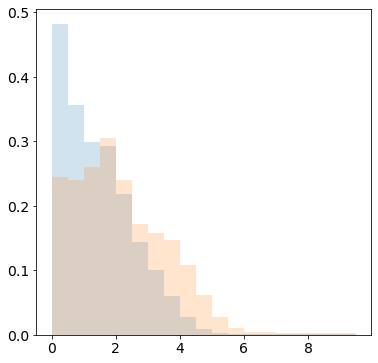

In [82]:
plt.hist(mlp_qcdloss, bins=np.arange(0,10,0.5), alpha=0.2, density=True)
plt.hist(mlp_mixtureloss, bins=np.arange(0,10,0.5), alpha=0.2, density=True)

In [83]:
threshold = np.linspace(0,10,1001)

tpr_list = []
for cutoff in threshold:
    tpr_list.append(np.where(mlp_mixtureloss>cutoff)[0].shape[0]/len(mlp_mixtureloss))

In [86]:
tpr_list = np.array(tpr_list)

In [13]:
#np.where(mlp_mixtureloss>4.3)

In [12]:
#np.where(tpr_list<0.05)

In [90]:
mlp_label = np.zeros(600000)

mlp_label[np.where(mlp_mixtureloss>4.3)] = 1

In [14]:
def get_loss(model, dm, originalset):
    predicted_set = trainer.predict(model, dm)
    prediction = np.empty((0,48))
    for batch in predicted_set:
        prediction = np.vstack((prediction, batch.cpu().numpy()))
    

    original = np.empty((0,48))
    originalloader = DataLoader(originalset, batch_size=1000)
    for batch, _ in originalloader:

        original = np.vstack((original, batch.cpu().numpy().reshape(-1,48)))
    
    loss = nn.MSELoss(reduction='none')
    loss_result = torch.sum(loss(torch.FloatTensor(prediction),torch.FloatTensor(original)),dim=1)
    return loss_result.cpu().numpy()

In [15]:
def get_predictx(originalset):
    original = np.empty((0,48))
    originalloader = DataLoader(originalset, batch_size=1000)
    for batch, _ in originalloader:
        #print(batch.size())
        original = np.vstack((original, batch.cpu().numpy().reshape(-1,48)))
    return original

In [ ]:
qcdoriginal = get_predictx(qcd_original_set)

original = get_predictx(mixture_original_set)

original = original[100000:]

qcdloss = get_loss(model, qcd_dm, qcd_original_set)

mixtureloss = get_loss(model, mixture_dm, mixture_original_set)

qcdloss.shape

mixtureloss.shape

mixtureloss = mixtureloss[100000:]

mixtureloss.shape

with open('AE_qcdloss.pickle', 'wb') as handle:
    pickle.dump(qcdloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('AE_sigloss.pickle', 'wb') as handle:
    pickle.dump(mixtureloss, handle, protocol=pickle.HIGHEST_PROTOCOL)







mixtureloss = mixtureloss[100000:]

with open('mlp_qcdloss.pickle', 'wb') as handle:
    pickle.dump(mlp_qcdloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('mlp_sigloss.pickle', 'wb') as handle:
    pickle.dump(mlp_mixtureloss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
threshold = np.linspace(0,10,1001)
print(threshold)
np.where(mixtureloss>1)[0].shape

tpr_list = []
for cutoff in threshold:
    tpr_list.append(np.where(mixtureloss>cutoff)[0].shape[0]/len(mixtureloss))

In [60]:
tpr_list = np.array(tpr_list)

In [62]:
tpr_list

array([1.        , 0.99958667, 0.97908167, ..., 0.026125  , 0.02610833,
       0.02609667])

In [65]:
threshold[732]

7.32

In [100]:
original.shape

torch.Size([600000, 48])

In [19]:
label = np.zeros(600000)

label[np.where(mixtureloss>2.41)] = 1

In [20]:
label[:10]

array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

In [21]:
np.where(mixtureloss>2.41)

(array([     3,      7,     13, ..., 599914, 599925, 599976]),)

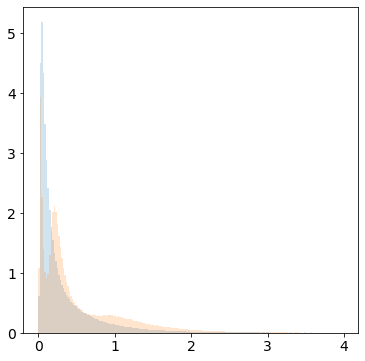

In [59]:
plt.hist(qcdloss, bins=np.arange(0,4,.02),alpha=0.2, density=True);
plt.hist(mixtureloss, bins=np.arange(0,4,.02),alpha=0.2, density=True);

In [30]:
#embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-v0-checkpoint-epoch=01-val_loss=0.55.ckpt")

In [ ]:
embedder = ManifoldEmbedder.load_from_checkpoint("../training/simulatedtoyjets_checkpoints/Transformer-paper-finaltuning-try14-epoch=00-val_loss=0.27.ckpt")

embedder.eval()

original.shape

qcdoriginal.shape

qcd_loader = DataLoader(torch.FloatTensor(qcdoriginal),batch_size=5000)

qcdembedded.shape

qcdembedded = np.empty((0,2))
for batch in tqdm(qcd_loader):
    print(batch.size(0))
    qcdembedded = np.vstack([qcdembedded, embedder(batch.view(batch.size(0), 16, 3)).detach().numpy()])

with open('embedded_qcd.pickle', 'wb') as handle:
    pickle.dump(qcdembedded, handle, protocol=pickle.HIGHEST_PROTOCOL)



inference_loader = DataLoader(torch.FloatTensor(original),batch_size=5000)

from tqdm import tqdm

embedded = np.empty((0,2))
for batch in tqdm(inference_loader):
    print(batch.size(0))
    embedded = np.vstack([embedded, embedder(batch.view(batch.size(0), 16, 3)).detach().numpy()])

embedded

label[:10]

with open('embedded_mixture.pickle', 'wb') as handle:
    pickle.dump(embedded, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('embedded_label_autoencoder.pickle', 'wb') as handle:
    pickle.dump(label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [91]:
with open('embedded_label_mlp.pickle', 'wb') as handle:
    pickle.dump(mlp_label, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
mlp_label[:10]

array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

In [ ]:
label

In [102]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d


In [103]:
hull_AE = ConvexHull(embedded[label==1])

In [104]:
hull_mlp = ConvexHull(embedded[mlp_label==1])

In [110]:
points_AE = embedded[label==1]
points_mlp = embedded[mlp_label==1]

In [111]:
ax.plot(points_AE[hull_AE.vertices,0], points_AE[hull_AE.vertices,1], 'r--', lw=2)

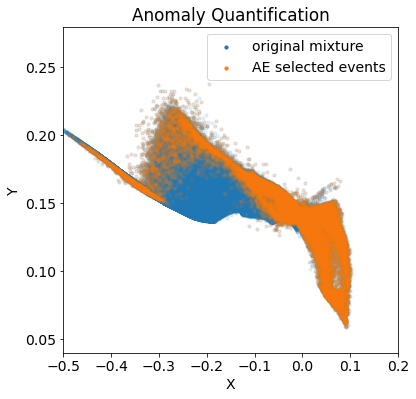

In [115]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(embedded[:,0],embedded[:,1],s=10,alpha=0.10,label='original mixture')
ax.scatter(embedded[label==1][:,0],embedded[label==1][:,1],s=10,alpha=0.10,label='AE selected events')
#ax.scatter(embedded[mlp_label==1][:,0],embedded[mlp_label==1][:,1],s=10,alpha=0.20,label='MLP selected events')
#ax.plot(points_AE[hull_AE.vertices,0], points_AE[hull_AE.vertices,1], 'C1--', lw=2)

#ax.plot(points_MLP[hull_MLP.vertices,0], points_MLP[hull_MLP.vertices,1], 'r--', lw=2)

#ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-0.5,0.2])
ax.set_ylim([0.04,0.28])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_title('Anomaly Quantification')    
fig.savefig(f'../figures/paper/anomaly_quantification_AE.png')    
fig.savefig(f'../figures/paper/anomaly_quantification_AE.pdf')

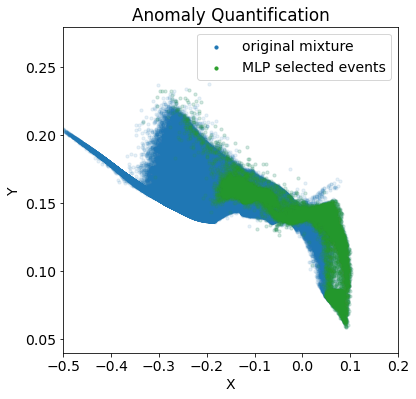

In [117]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(embedded[:,0],embedded[:,1],s=10,alpha=0.10,label='original mixture')
#ax.scatter(embedded[label==1][:,0],embedded[label==1][:,1],s=10,alpha=0.10,label='AE selected events')
ax.scatter(embedded[mlp_label==1][:,0],embedded[mlp_label==1][:,1],s=10,alpha=0.10,color="C2",label='MLP selected events')
#ax.plot(points_AE[hull_AE.vertices,0], points_AE[hull_AE.vertices,1], 'C1--', lw=2)

#ax.plot(points_MLP[hull_MLP.vertices,0], points_MLP[hull_MLP.vertices,1], 'r--', lw=2)

#ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-0.5,0.2])
ax.set_ylim([0.04,0.28])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_title('Anomaly Quantification')    
fig.savefig(f'../figures/paper/anomaly_quantification_MLP.png')    
fig.savefig(f'../figures/paper/anomaly_quantification_MLP.pdf')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(embedded[:,0],embedded[:,1],s=10,alpha=0.20,label='original mixture')
ax.scatter(embedded[label==1][:,0],embedded[label==1][:,1],s=10,alpha=0.20,label='AE selected events')
ax.scatter(embedded[mlp_label==1][:,0],embedded[mlp_label==1][:,1],s=10,alpha=0.20,label='MLP selected events')
#ax.plot(points_AE[hull_AE.vertices,0], points_AE[hull_AE.vertices,1], 'C1--', lw=2)

#ax.plot(points_MLP[hull_MLP.vertices,0], points_MLP[hull_MLP.vertices,1], 'r--', lw=2)

#ax.scatter(embedding[label==i][:1000,0],embedding[label==i][:1000,1],s=10,alpha=0.20,label=namelist[i])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim([-0.5,0.2])
ax.set_ylim([0.04,0.28])
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
ax.set_title('Anomaly Quantification')    
fig.savefig(f'../figures/paper/anomaly_quantification_AE.png')    
fig.savefig(f'../figures/paper/anomaly_quantification_AE.pdf')

In [57]:
predicted_qcd = trainer.predict(model, qcd_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [58]:
predicted_mixture = trainer.predict(model, mixture_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [64]:
qcd_original_set = torch.load('/nobackup/users/sangeon/datasets/jetGridpack/jetanomaly/autoencoder_predict.pt')

In [69]:
qcd_original = np.empty((0,48))
for batch, _ in qcd_original_set:
    qcd_original = np.vstack((qcd_original, batch.cpu().numpy().reshape(-1,48)))

KeyboardInterrupt: 

In [59]:
qcd = np.empty((0,48))
for batch in predicted_qcd:
    qcd = np.vstack((qcd, batch[0].cpu().numpy()))

In [61]:
qcd.shape

(300, 48)

In [60]:
mixture = np.empty((0,48))
for batch in predicted_mixture:
    mixture = np.vstack((mixture, batch[0].cpu().numpy()))

In [25]:
type(original)

numpy.ndarray

In [26]:
loss_qcd = DataLoader(torch.FloatTensor(original),batch_size=2000)

NameError: name 'Dataloader' is not defined

In [55]:
predicted_mixture

[{'test_loss': 0.019474703818559647, 'test_loss_epoch': 0.019474703818559647}]

In [48]:
loss_qcd

[{'test_loss': 0.008486421778798103, 'test_loss_epoch': 0.008486421778798103}]

TypeError: '<' not supported between instances of 'dict' and 'float'

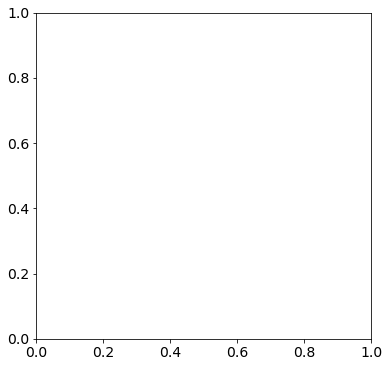

In [47]:
plt.hist(loss_qcd)

In [1]:
model_a1 = 
model_a2 = 


SyntaxError: invalid syntax (2582325179.py, line 1)

In [ ]:
def select_points()

In [2]:
def get_roc_curve

SyntaxError: invalid syntax (3993882320.py, line 1)

In [3]:
def evaluate(model,tpr)

SyntaxError: invalid syntax (3844852893.py, line 1)

In [ ]:
def area_ratio_coverage

In [4]:
def area_coverage

SyntaxError: invalid syntax (1599810017.py, line 1)

In [5]:
def convexhull 

SyntaxError: invalid syntax (843246886.py, line 1)